In [1]:
from skimage.io import imread
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from collections import Counter

%matplotlib inline

In [2]:
!pip install opencv-contrib-python==3.4.2.17



     |████████████████████████████████| 30.6MB 137kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
import cv2

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [1]:
!pwd
PATH = '/content/drive/MyDrive/'
PATH_AFTER_MYDRIVE = 'MSC_DATA_SCIENCE/ComputerVision_CW/'
FINAL_PATH = PATH + PATH_AFTER_MYDRIVE
%cd $FINAL_PATH

/content
[Errno 2] No such file or directory: '/content/drive/MyDrive/MSC_DATA_SCIENCE/ComputerVision_CW/'
/content


In [6]:
!pwd

/content/drive/MyDrive/MSC_DATA_SCIENCE/ComputerVision_CW


In [8]:
test_images  = np.load('generated_data/test_images.npy')
train_images = np.load('generated_data/train_images.npy')
print(np.shape(test_images),'- Test Image Array Shape')
print(np.shape(train_images),'- Train Image Array Shape')

(3068, 100, 100, 3) - Test Image Array Shape
(12271, 100, 100, 3) - Train Image Array Shape


In [10]:
import pandas as pd
train_labels = pd.read_csv('labels/list_label_train.txt',delimiter = "\s+",names = ['File','Class'])
test_labels = pd.read_csv('labels/list_label_test.txt',delimiter = "\s+",names = ['File','Class'])

In [11]:
num2emo = ['Suprise','Fear','Disgust','Happiness','Sadness','Anger','Neurtral']

In [16]:
print(train_labels['Class'].value_counts())
y_train = train_labels['Class'].to_numpy()

4    4772
7    2524
5    1982
1    1290
3     717
6     705
2     281
Name: Class, dtype: int64


In [17]:
print(test_labels['Class'].value_counts())
y_test = test_labels['Class'].to_numpy()

4    1185
7     680
5     478
1     329
6     162
3     160
2      74
Name: Class, dtype: int64


In [18]:
y_train = y_train-1
y_test  = y_test-1
print(min(y_train),max(y_train),'Training Minmax')
print(min(y_train),max(y_train),'Training Minmax')

0 6 Training Minmax


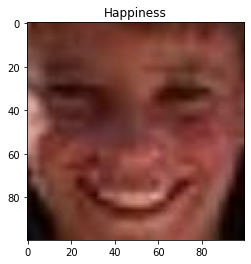

In [ ]:
#Example image
plt.imshow(train_images[666])
plt.title(num2emo[y_train[666]])
plt.show()

In [ ]:
# Feature Extractors:
#       - SIFT with and without BOW 
#       - HOG


In [ ]:
#Adopted from CV lab 07, City University 


# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(train_images)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(train_images[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Show results for first 4 images
    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])
        #print(len(des)) Len of descriptors is not constant 

fig.tight_layout()
plt.show()


In [ ]:
# Convert to array for easier handling
des_array = np.vstack(des_list)

In [ ]:
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 100
print(batch_size)
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

7154


In [ ]:
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

In [ ]:
np.save('SIFT_DES_trainx.npy',hist_array)
np.save('SIFT_DES_trainy.npy',y_train_list)

In [ ]:
hist_list_test = []

for i in range(len(test_images)):
    img = img_as_ubyte(color.rgb2gray(test_images[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list_test.append(hist)

    else:
        hist_list_test.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list_test) if x is not None]
hist_list_test = [hist_list_test[i] for i in idx_not_empty]
y_test_out = [y_test[i] for i in idx_not_empty]
hist_array_test = np.vstack(hist_list_test)

In [ ]:
np.save('SIFT_DES_testx.npy',hist_array_test)
np.save('SIFT_DES_testy.npy',y_test_out)

In [ ]:
#FEATURE DESCRIPTOR 2: HOG

In [ ]:
from skimage.feature import hog 
from skimage import exposure

In [ ]:
fd, im_out = hog(train_images[10], orientations=8, pixels_per_cell=(10,10),
                    cells_per_block=(1, 1), visualize=True, multichannel=True,feature_vector=True)

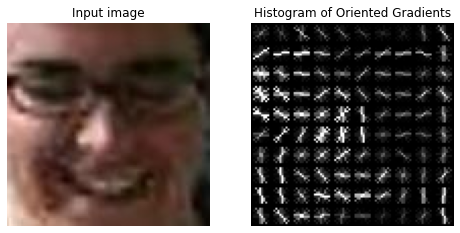

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(train_images[10], cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(im_out, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()



In [ ]:
print(len(fd)) #Length of feature vector from HOG 
print(len(train_images)) #Train Images length


800
12271


In [ ]:
hog_train = np.zeros((len(train_images),len(fd)))
for ind,image in enumerate(train_images):
  hog_train[ind,:],_ = hog(image, orientations=8, pixels_per_cell=(10,10),
                    cells_per_block=(1, 1), visualize=True, multichannel=True,feature_vector=True)
hog_test = np.zeros((len(test_images),len(fd)))
for ind,image in enumerate(test_images):
  hog_test[ind,:],_ = hog(image,orientations=8, pixels_per_cell=(10,10),
                    cells_per_block=(1, 1), visualize=True, multichannel=True,feature_vector=True)

In [ ]:
np.save('HOG_DES_train.npy',hog_train)
np.save('HOG_DES_test.npy',hog_test)